C:\Users\Kptha\anaconda3\envs\spanwise_gust\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\Kptha\anaconda3\envs\spanwise_gust\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Kptha\anaconda3\envs\spanwise_gust\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


actor using:  cpu
Critic using:  cpu
... loading models ...
deflection: 600


C:\Users\Kptha\OneDrive\Documents\Research\Spanwise_uniform_gust_response\Spanwise_uniform_gust_response\ppo_torch_conv1d.py:170: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  state = T.tensor([observation], dtype=T.float).to(self.actor.device)


deflection: -600
deflection: 600
deflection: -600
deflection: 600
deflection: -600
deflection: 600
deflection: -600
deflection: 600
deflection: -600
deflection: 600
deflection: -600
deflection: 600
deflection: -600
deflection: 600
deflection: -600
deflection: 600
deflection: -600
deflection: 600
deflection: -600
deflection: 900
deflection: -900
deflection: 900
deflection: -900
deflection: 900
deflection: -900
deflection: 900
deflection: -900
deflection: 900
deflection: -900
deflection: 900
deflection: -900
deflection: 900
deflection: -900
deflection: 900
deflection: -900
deflection: 900
deflection: -900
deflection: 900
deflection: -900
deflection: 1200
deflection: -1200
deflection: 1200
deflection: -1200
deflection: 1200
deflection: -1200
deflection: 1200
deflection: -1200
deflection: 1200
deflection: -1200
deflection: 1200
deflection: -1200
deflection: 1200
deflection: -1200
deflection: 1200
deflection: -1200
deflection: 1200
deflection: -1200
deflection: 1200
deflection: -1200


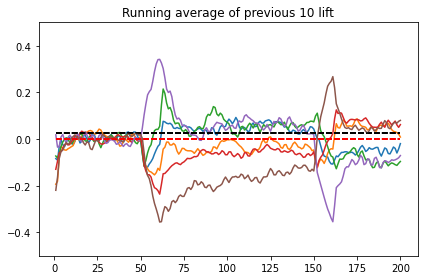

In [1]:
import matplotlib.pyplot as plt
import gym
import numpy as np
from ppo_torch_conv1d import Agent
from utils import plot_learning_curve
from utils import plot_test_curve
import uniform_gust_test_environment_diff as u_gust_env
import spanwise_gust_test_environment_diff as s_gust_env
#import gust_test2_environment as gust_env

import time


if __name__ == '__main__':
    #env = gym.make('CartPole-v1')
    #env = MFC_aileron_env_discrete_pytorch_variable_target.MFC_aileron_Env()
    steps_ep = 200
    seed = 1  #ahave done(1, 2, 3 )
    speed = 15
    batch_size = 5
    n_epochs = 4
    alpha = 0.00003
    N = 20
    UvS = 'uniform'
    defls = [600,900,1200]
    defl = defls[0]
    tap = 6
    end = True
        
    if end:
        saved = 'end'
    else:
        saved = 'top'
    if UvS == 'spanwise':
        env = s_gust_env.mfc_gust_Env(deflect = defl, steps_per_ep = steps_ep, seed=seed)
        uvs = 'span'
        obs_hist_shape = (tap+2,steps_ep)
        act_avg = False
        act_mode = True
    else:
        env = u_gust_env.mfc_gust_Env(deflect = defl, steps_per_ep = steps_ep, seed=seed)
        uvs = 'uni'
        obs_hist_shape = (tap+1,steps_ep)
        act_avg = True
        act_mode = False
    
    
    figure_file = 'plots/wing_test_seed2.png'    
    file = 'spanwise/speed'+str(speed)+'/uniform_comp/seed'+str(seed)+'/'+str(tap)+'tap'
    agent_file = 'Mar_31_'+uvs+'_sp' +str(speed)+'_'+str(tap)+'tap_seed'+str(seed)+'/'
    #agent_file = 'Feb_6_uni_sp10_seed'+str(seed)
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                    alpha=alpha, n_epochs=n_epochs, 
                    input_dims=env.observation_space.shape, 
                    fc1_dims=512, fc2_dims=512, chk_dir=file+'/ppo/'+agent_file,
                    seed=seed)
  

    
    agent.load_models(end=end)
    best_score = env.reward_range[0]
    
    for defln in defls:
        
        n_games = 20
        test_num = 0
        for i in range(n_games):
            env.end()
            if i%2==0:
                defl = defln
                test_num += 1
            else:
                defl = -defln
            print('deflection: '+str(defl))
            
            if defl>0:
                direct = 'up'
            else:
                direct = 'down'
            
            if UvS == 'spanwise':
                env = s_gust_env.mfc_gust_Env(deflect = defl, steps_per_ep = steps_ep, seed=seed)
        
            else:
                env = u_gust_env.mfc_gust_Env(deflect = defl, steps_per_ep = steps_ep, seed=seed)
                
            observation = env.reset()
            done = False
            score = 0
            learn_iters = 0
            avg_score = 0
            n_steps = 0
        
            lift_history = []
            drag_history = []
            time_hist = [0]
            obs_hist = np.zeros(obs_hist_shape)
            act_hist = []
            t = time.time()
            while not done:
                
                if not env.g_rotating:
                    
                    action, prob, val = agent.choose_action(observation, avg=act_avg, mode=act_mode)
                    #action = 0
                    #if env.num_steps < 150:
                     #   action = 1
                    #if env.num_steps >= 150:
                       # action = 2 
                    #if env.num_steps >157:
                        #action = 1
                    #if env.num_steps > 177:
                        #action = 0
                    #if env.num_steps > 184:
                        #action = 1
                    
                    observation_, reward, done, lift, drag = env.step(action)
                    score += reward
                    agent.remember(observation, action, prob, val, reward, done)
                    observation = observation_
                    obs_hist[:,n_steps] = observation[:,-1]
                    lift_history.append(lift)
                    drag_history.append(drag)
                    t_ = time.time()
                    dt = t_ - t
                    t = t_
                    time_hist.append(dt+time_hist[-1])
                    n_steps+=1
                else:
                    env.check_table()
                    #action, _, _ = agent.choose_action(observation, avg=True)
                    #_, _, _, _ = env.step(action, skip=True)
                    env.pause_for_timing()
    
                x = [i+1 for i in range(len(lift_history))]
        
        
            np.savetxt(file+'/testing/'+str(tap)+'tap_Test_'+uvs+'_sp'+str(speed)+'_seed'+str(seed)+
                       '_'+saved+'_g'+str(defl)+'_'+direct+'_'+str(test_num)+'.csv', (lift_history,drag_history), delimiter =",")
            np.savetxt(file+'/testing/'+str(tap)+'tap_Test_'+uvs+'_sp'+str(speed)+'_seed'+str(seed)+
                       '_'+saved+'_g'+str(defl)+'_'+direct+'_'+str(test_num)+'_obs.csv', obs_hist, delimiter=',')
            np.savetxt(file+'/testing/'+str(tap)+'tap_test_'+uvs+'_sp'+str(speed)+'_seed'+str(seed)+
                       '_'+saved+'_g'+str(defl)+'_'+direct+'_'+str(test_num)+'_time.csv', time_hist, delimiter=',')
            #np.savetxt(UvS+'/speed'+str(speed)+'/Baseline/baseline_sp'+str(speed)+'_g'+str(defl)+'_'+direct+'_'+str(test_num)+'.csv', (lift_history,drag_history), delimiter =",")
            #np.savetxt(UvS+'/speed'+str(speed)+'/Baseline/baseline_sp'+str(speed)+'_g'+str(defl)+'_'+direct+'_'+str(test_num)+'_obs.csv', obs_hist, delimiter=',')
            #np.savetxt(UvS+'/speed'+str(speed)+'/Baseline/baseline_sp'+str(speed)+'_g'+str(defl)+'_'+direct+'_'+str(test_num)+'_timing.csv', time_hist, delimiter=',')
            if i == 0:
                plot_test_curve(x,lift_history, drag_history, figure_file, avg_of=10)
            elif i == 1:
                plot_test_curve(x,lift_history, drag_history, figure_file, avg_of=10)
    env.end()
  

In [2]:
max(0,10)

10

[[-1.3456517  -1.33085164 -1.34854736 -1.34114733 -1.2803384  -1.35015606
  -1.30189501 -1.36753004 -1.36109523 -1.33825167]
 [-0.47335474 -0.49523352 -0.47367649 -0.46531107 -0.48461588 -0.46981553
  -0.51325134 -0.39066579 -0.47464173 -0.47431998]
 [-0.20318388 -0.21283631 -0.23664564 -0.21541029 -0.25755924 -0.20447087
  -0.21154932 -0.23342816 -0.17680056 -0.21508855]
 [-0.10498627 -0.09855132 -0.10691676 -0.09983831 -0.25556404 -0.10241229
  -0.10273404 -0.0950121  -0.12429112 -0.10820375]
 [ 0.03108069  0.02110655 -0.0091376   0.02368052 -0.00302442  0.02915021
   0.02207179  0.01306289  0.01434988  0.0214283 ]
 [-0.06415588 -0.0570775  -0.04292073 -0.07702566 -0.09311288 -0.0059201
  -0.04452946 -0.07252123 -0.04645992 -0.05900796]
 [-0.4        -0.4        -0.4        -0.4        -0.4        -0.4
  -0.4        -0.4        -0.4        -0.4       ]]
[ 0.02110392 -0.03992916 -0.20016806  0.02012013  0.18190118 -0.02317414
 -0.15330816  0.07873324  0.19627954 -0.04540811]
[1.884747

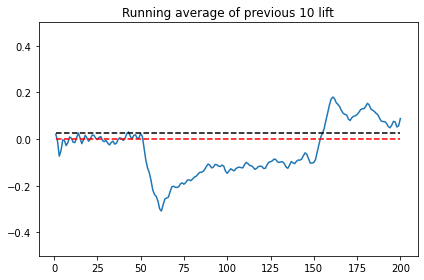

In [3]:

print(obs_hist[:,100:110])
print(lift_history[0:10]-np.mean(lift_history[:49]))
print(drag_history[130:150])
print(lift_history[0:10])
print(np.mean(lift_history[30:50])-np.mean(lift_history[:49]))
print(np.mean(lift_history[100:149])-np.mean(lift_history[:49]))
plot_test_curve(x,lift_history, drag_history, figure_file, avg_of=10)

rls = np.zeros((200,10))
bases = np.zeros((200,10))
for i in range(10):
    ii = i+1
    rls[:,i] = np.loadtxt('uniform/speed10/seed2/3tap/testing/3tap_Test_'+uvs+'_sp'+str(speed)+'_seed2_'
                          +'end_g1600_up_'+str(ii)+'.csv')
    bases[:,i] = np.loadtxt('Baselines/speed10/baseline_sp10_seed1_g1600_up_'+
                            str(ii)+'.csv')
rldiff = rls[51:149,:]-np.mean(rls[:49,:])
basediff = np.mean(bases[52:149,:])-np.mean(bases[:45,:])

settled_rl = np.mean(rldiff[-50:,:], axis=0)
mean_rl = np.mean(rldiff, axis=1)

#plot_test_curve(x,bases[:,0], drag_history, figure_file, avg_of=10)

plt.plot(np.arange(len(mean_rl)),abs(mean_rl/basediff))
settled = np.mean(abs(settled_rl))/basediff
print(settled)
plt.plot(np.arange(len(rldiff)), np.ones(len(rldiff))*settled)
plt.ylim([0,1])